# 인물사진을 만들어 보자

## 셸로우 포커스 만들기

### (1) 사진을 준비하자

In [1]:
import os
import urllib    # 웹에서 데이터를 다운로드할 때 사용
import cv2    # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation    # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

(3024, 4032, 3)


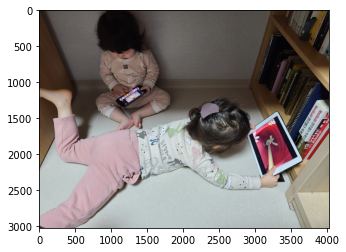

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_daughter.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 세그멘테이션으로 사람 분리하기
### (3) 시맨틱 세그멘테이션 다뤄보기

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0ef0ba1580>)

In [4]:
# PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

* segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트 : PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미


In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

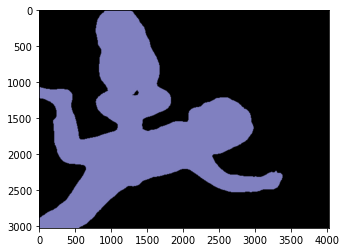

In [7]:
# 모델에서 나온 출력값 확인
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


* output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있음.
* segvalues에는 class_ids와 masks가 있음.

In [10]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인

# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]    # colormap은 RGB 순서

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 우리가 추출해야 하는 색상 값 순서 변경
seg_color = (128,128,192)

(3024, 4032)


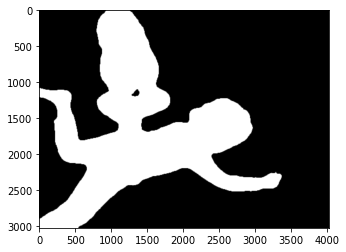

In [12]:
# seg_color로만 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

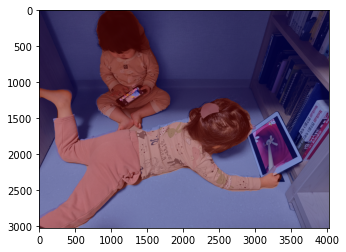

In [13]:
# 원본 이미지와 합성

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (4) 배경 흐리게 하기

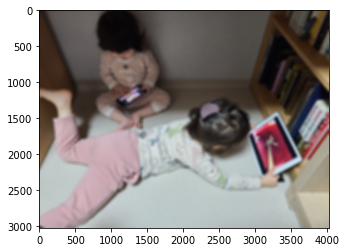

In [14]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

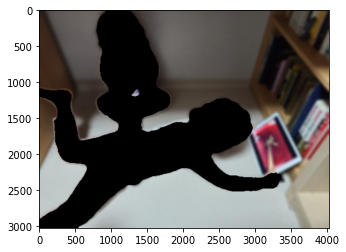

In [15]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 함수 : 이미지가 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)    # bitwise_and 연산 : 배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 흐린 배경과 원본 영상 합성

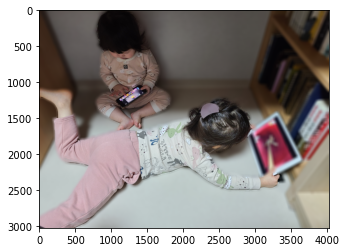

In [16]:
# 배경 영상과 사람 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

*****

# Step 1. 인물모드 직접 해 보기

* 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.

* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### 1. 인물사진 (1) 사람

(2172, 3024, 3)


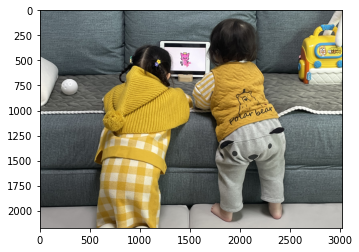

In [17]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_daughter1.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

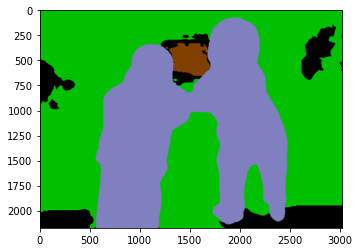

In [18]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [19]:
segvalues

{'class_ids': array([ 0, 15, 18, 20]),
 'masks': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [20]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
sofa
tv


In [21]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [22]:
seg_color = (128,128,192)

(2172, 3024)


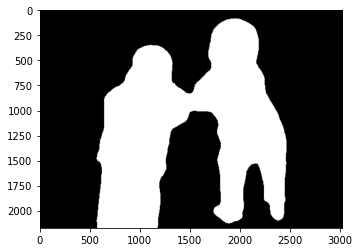

In [23]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

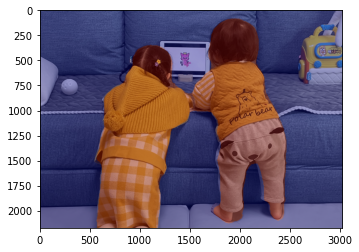

In [24]:
# 원본 이미지와 합성

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

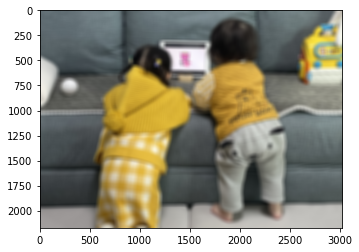

In [25]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

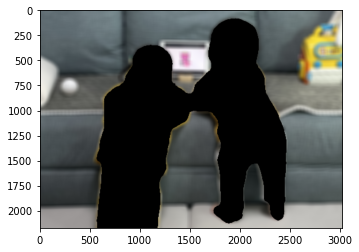

In [26]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 함수 : 이미지가 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)    # bitwise_and 연산 : 배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

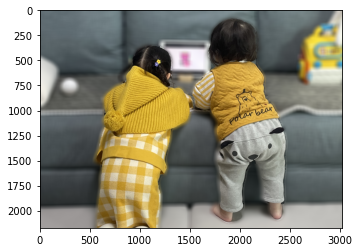

In [27]:
# 배경 영상과 사람 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

*****

(2244, 3024, 3)


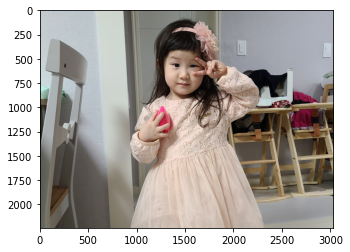

In [28]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_daughter2.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

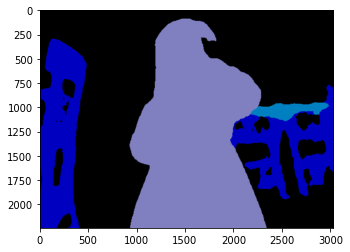

In [29]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [30]:
segvalues

{'class_ids': array([ 0,  9, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [31]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person


In [32]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [33]:
seg_color = (128,128,192)

(2244, 3024)


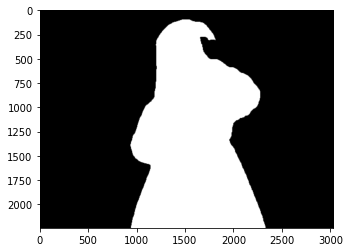

In [34]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

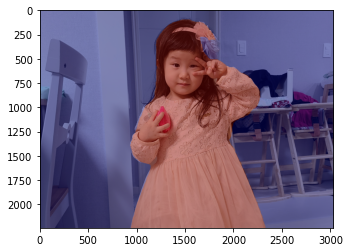

In [35]:
# 원본 이미지와 합성

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

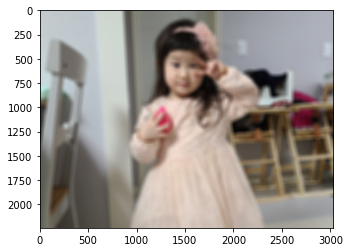

In [36]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

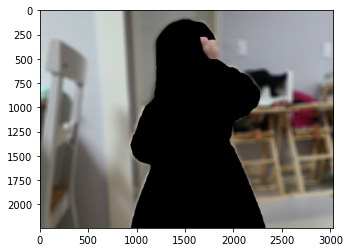

In [37]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 함수 : 이미지가 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)    # bitwise_and 연산 : 배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

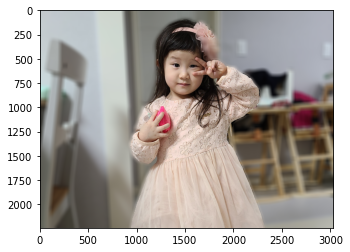

In [38]:
# 배경 영상과 사람 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

*****

(3024, 3756, 3)


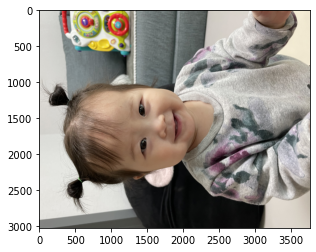

In [39]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_daughter3.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

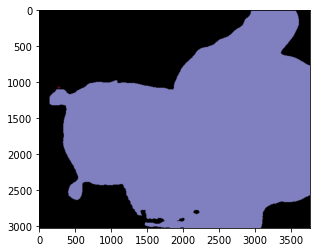

In [40]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [41]:
segvalues

{'class_ids': array([ 0, 12, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [42]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog
person


In [43]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [44]:
seg_color = (128,128,192)

(3024, 3756)


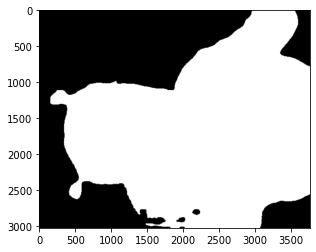

In [45]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

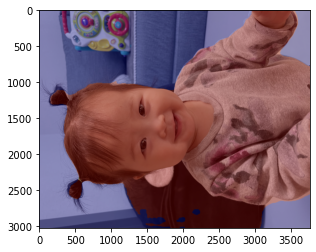

In [46]:
# 원본 이미지와 합성

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

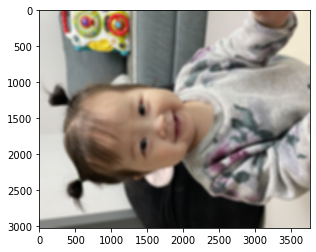

In [47]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

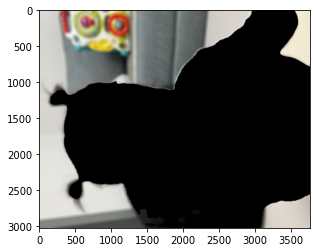

In [48]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 함수 : 이미지가 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)    # bitwise_and 연산 : 배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

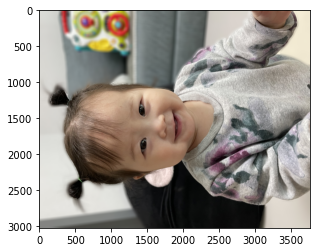

In [49]:
# 배경 영상과 사람 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

*****

###  1. 인물사진 (2) 고양이

(1440, 1080, 3)


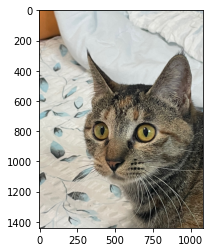

In [50]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/love_cat.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

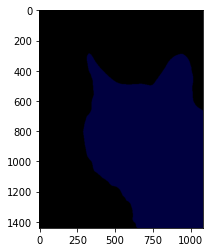

In [51]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [52]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [53]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [54]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [55]:
seg_color = (0,0,64)

(1440, 1080)


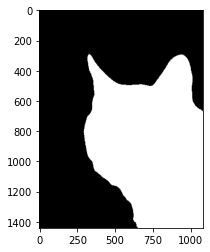

In [56]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

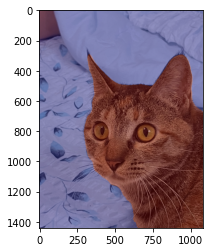

In [57]:
# 원본 이미지와 합성

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

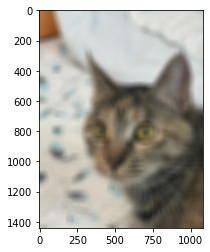

In [58]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

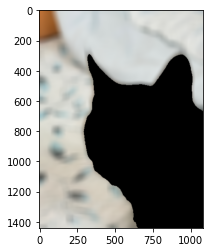

In [59]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 함수 : 이미지가 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)    # bitwise_and 연산 : 배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

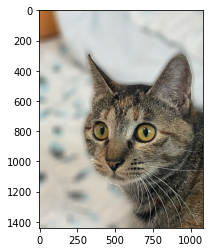

In [60]:
# 배경 영상과 고양이 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

*****

### 1. 인물사진 (3) 크로마키(배경 합성)

(1280, 1920, 3)


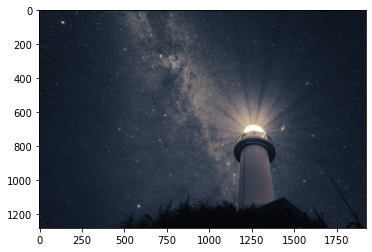

In [61]:
# 크로마키 할 배경이미지

bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey.jpg'
bg_img_orig = cv2.imread(bg_img_path)

print(bg_img_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1440, 1080, 3)


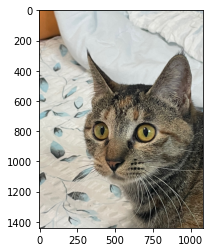

In [62]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/love_cat.jpg'
cat_img_orig = cv2.imread(cat_img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [63]:
# 배경 이미지와 고양이 이미지 크기 맞추기
target_size = (cat_img_orig.shape[1], cat_img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size) # # 배경 이미지를 target size 크기로 resize 합니다.

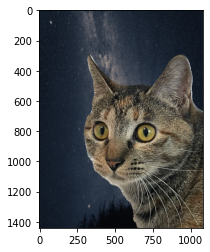

In [64]:
# 배경과 원본 이미지 합성

cat_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, cat_img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 배경이미지를 기준으로 고양이 이미지의 크기를 맞춰 보려고 했으나 계속 에러가 나서 포기.
* 그래서 배경 이미지를 고양이 사진을 기준으로 사이즈를 맞추고 고양이 이미지 크기를 줄이려고 시도 했지만 그것도 실패.(배경 이미지 등대 위치에 고양이를 배치해서 고양이 머리부분이 빛나는걸 표현하고 싶었음.)
* 크로마키(배경 합성)는 고양이 이미지 + 배경 이미지 합성으로 만족했다.

*****

# Step 2. 사진에서 문제점 찾기

* 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

* 추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

[my_image]
![my_image_problem](https://user-images.githubusercontent.com/96759124/150925203-cacf2935-3c00-47a8-829c-528c4e18944b.jpeg)

[my_daughter]
![my_daughter_problem](https://user-images.githubusercontent.com/96759124/150925208-1d3e98b3-a243-4e0a-891f-dd5e6a77f740.jpeg)

[my_daughter1]
![my_daughter1_problem](https://user-images.githubusercontent.com/96759124/150925209-1dfb5da6-ab09-4186-9677-b0213a416d96.jpeg)

[my_daughter2]
![my_daughter2_problem](https://user-images.githubusercontent.com/96759124/150925212-dc48785a-3a8a-4e1b-a5b3-bc9746983762.jpeg)

[my_daughter3]
![my_daughter3_problem](https://user-images.githubusercontent.com/96759124/150925210-b9d73b39-dfbd-4725-ac9b-ebb6cbe3281e.jpeg)

[love_cat]
![love_cat_problem](https://user-images.githubusercontent.com/96759124/150925214-97fff5a3-a455-4ce2-a8a7-c8d9b1672905.jpeg)


* 공통적인 문제점으로 경계 부분이 깔끔하지 못함.(인물 부분에서 blur 처리 되는 부분이 발생함.)

* [my_daughter2] 같은 경우 머리장식이 날아감.

* [my_daughter3] 가로 이미지 같은 경우 사람 인식이 잘 안됨. 뒤에 쿠션도 같이 잡힘.

* 아이폰으로 촬영한 사진인데 기존 사진 방향은 세로 방향인데 모델에 이미지를 입력하는 과정에서 세로 이미지가 가로 이미지로 방향이 바뀜. 추가한 3장 모두 같은 문제가 발행하여 임의로 사진을 가로 이미지로 잘라서 다시 불러옴. 정상적으로 모델에 이미지가 입력됨.

* 문제점은 마스크 된 이미지는 가로 방향이나 원본 이미지(배경 이미지)는 세로 방향이라서 두 이미지의 사이즈가 맞지 않음.

* [my_daughter3]도 원래는 세로 방향이였으나 가로 방향으로 인식되서 아예 이미지를 90도 시계방향으로 회전시켜 불러옴.

* 아이폰으로 촬영한 이미지만 이런 문제가 발행하는건지 왜 모델에 입력하면 세로 이미지가 자동으로 가로 이미지로 전환됨. (안드로이드로 촬영한 사진으로는 테스트 해보진 못했다.)

*****

# Step 3. 해결 방법을 제안해 보기

* 세그멘테이션의 한계
* 피사계 심도 이해하기
* 3D Camera 활용하기
* 소프트웨어 기술 활용하기
* 다른 기술과 융합해 보기

## 솔루션 제안

가장 크게 부각되는 문제점은 아무래도 경계부분이 깔끔하지 못한 부분같다.
근본적으로 보면 초점이 잡힌 부분과 그 외의 부분을 섬세하게 구분하지 못해서 생긴 문제점 같아 보인다. 세그멘테이션의 부정확성이 주요 원인으로 보인다.

피사계 심도를 이용한 보케(아웃포커싱) 효과는 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별된다.

그러나, 아이폰의 아웃포커싱과 같이 기계적인 조작으로 만들어진 것이 아니라 소프트웨어를 통해 유사한 느낌을 준 것에 가까운 것처럼 하나의 렌즈만으로 비슷하게 흉내낸 시멘틱 세그멘테이션 모듈의 정확도로는 완벽하게 구현하기 힘들다.


아웃포커싱 하는 5가지 방법을 가지고 해결방안으로 접근했을 때,


1. 카메라의 이미지 센서가 클수록
- 이미지 센서란 카메라가 빛을 받아들이는 면적을 말한다.
카메라에서 센서 = 필름카메라의 필름과 같다. 비싸지만 좋은 카메라를 쓰고 비싸지만 렌즈를 별도로 구입하는 이유랄까..모델로 생각한다면 현재 우리가 사용한 시멘트 세그멘테이션 모델보다 상위 레벨(?)의 모델, 더 나은 모델을 사용하면 되지 않나 생각해본다.


2. 망원 렌즈를 쓰거나 줌을 했을 때
- 초점 거리는 렌즈의 중심으로부터 초점간의 거리를 말한다.
이미지 부분에 있어서 마스크 인식이 되지 않는 부분을 확대하여 별도로 마스크를 지정해주면 되지 않
을까 생각해본다.

3. 조리개가 많이 개방될 수록(F값이 작을 수록)
- 렌즈의 조리개 개방 정도를 나타내는 값을 말한다.
F값을 통해 심도를 조절하는 것인데 모델로 구현한다면 어떻게 표현해야할까..?
입력된 이미지를 여러번의 인식을 거쳐(동일한 모델에) 보다 정확한 인식을 하면 되지 않을까 생각해본다. 그러려면 모델 구성을 다시 해야할 것 같다.


4. 카메라와 피사체간의 거리가 가까울 때
5. 피사체와 배경과의 거리가 멀 수록
- 4~5번 방법은 모델로 구현할 수 있을까?
이미 촬영된 이미지를 가지고 아웃포커싱을 하기 때문에 대상과 배경의 거리에 변화를 줄 수 있는 방법으로 적절한게 있을까..

Exp7, 딥러닝에서는 하나의 렌즈만으로 인물사진 모드를 비슷하게 흉내를 내보았다.
핸드폰 인물사진 모드에서 힌트를 얻자면 핸드폰 인물사진 모드 같은 경우에는 화각이 다른 두 렌즈를 사용하는데, 일반(광각) 렌즈에서는 배경을 촬영하고, 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐르게 처리한 후 망원 렌즈의 인물과 적절하게 합성을 한다.


딥러닝에서 적용해 본다면, 화각이 다르게 촬영한 이미지 두 장을 준비하여 망원 렌즈의 역할을 하는 이미지의 배경을 흐리게 처리한 후 일반(광각) 렌즈의 역할을 하는 이미지와 합성을 하게 된다면 딥러닝 모델로도 보다 정교한 아웃포커싱 기능을 흉내낼 수 있지 않을까 생각해 본다.

## 회고

그 밖에 참고 자료를 조사하다 보니 대상과 배경 간의 경계 부분의 부자연스러움을 완화할 수 있는 방법으로 마스크에 블러 효과를 사용하면 된다고 한다. (하지만 거리감에 대한 문제를 해결 할 수 있진 않다.) 이 부분은 다른 방안들을 코드로 구현함에 비해 쉬울 것 같았지만 쉽지 않았다. 이번 프로젝트는 시도는 많이 해봤으나 방향성이나 코드 구현에 있어서 크고 작은 어려움들로 인해 포기하는 시도가 많았다.


나의 수준에서 현실적으로 접근할 수 있는 해결 방안으로는 인물모드 인식에 있어서 대상과 배경의 구분이 불분명 한 것은 마스크 처리에 대한 정확도가 떨어진다고 느꼈다.

그래서, 해상도가 높은 이미지를 사용하여 마스크 인지에 있어서 좀더 분명한 경계를 주거나 인식하지 못하는 부분을 확대하여 추가적으로 마스크 범위를 잡아주면 되지 않을까 라는 생각을 했다.
(우수 프로젝트 중 이미지의 일부를 확대하여 마스크 범위를 수작업으로 잡아준 분이 계시던데, 그 노드를 참고하여 이미지 마스크 범위 설정 시도해보려고 하다가 계속 오류가 나서 포기했다.)


또한, 하나의 이미지로 대상과 배경 간의 거리감을 무시하고 배경 전체에 동일하게 흐리게 처리하게 되서 부자연스러운 경계를 좀더 자연스럽게 하기 위해 마스크에 가우시안 블러 효과를 주면 경계 부분이 부드럽게 표현되지 않을까 생각했는데, 마스크에 블러 효과를 주는 시도를 하지 못해 아쉽다.